<a href="https://colab.research.google.com/github/Rahuldevelope/Detector/blob/main/liquid_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the CSV file
data = pd.read_csv('GOOG.csv', parse_dates=['Date'])

# Use the 'Close' column for prediction
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert the data to a supervised learning problem
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import torch
import torch.nn as nn

class LiquidTimeConstantLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LiquidTimeConstantLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.tau = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, x, hidden):
        pre_activation = self.input_to_hidden(x) + self.hidden_to_hidden(hidden)
        hidden = hidden + (pre_activation - hidden) / self.tau
        return hidden

class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.liquid_layer = LiquidTimeConstantLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hidden = torch.zeros(x.size(0), self.hidden_dim).to(x.device)
        for t in range(x.size(1)):
            hidden = self.liquid_layer(x[:, t, :], hidden)
        out = self.fc(hidden)
        return out

input_dim = 1
hidden_dim = 64
output_dim = 1

model = LiquidNeuralNetwork(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Convert numpy arrays to torch tensors
X_train_tensors = torch.from_numpy(X_train).float()
Y_train_tensors = torch.from_numpy(Y_train).float()

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensors)
    optimizer.zero_grad()
    loss = criterion(outputs, Y_train_tensors.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 0/100, Loss: 0.0882
Epoch 10/100, Loss: 0.0086
Epoch 20/100, Loss: 0.0032
Epoch 30/100, Loss: 0.0006
Epoch 40/100, Loss: 0.0005
Epoch 50/100, Loss: 0.0004
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0003
Epoch 80/100, Loss: 0.0003
Epoch 90/100, Loss: 0.0003


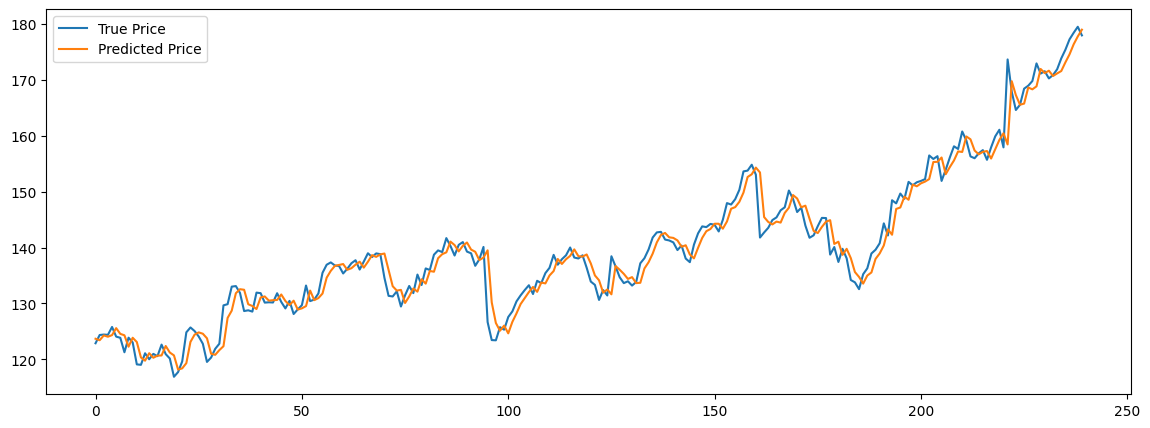

In [ ]:
model.eval()
X_test_tensors = torch.from_numpy(X_test).float()
Y_test_tensors = torch.from_numpy(Y_test).float()

predicted = model(X_test_tensors)
predicted = predicted.detach().numpy()
predicted = scaler.inverse_transform(predicted)

Y_test_true = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(Y_test_true, label='True Price')
plt.plot(predicted, label='Predicted Price')
plt.legend()
plt.show()


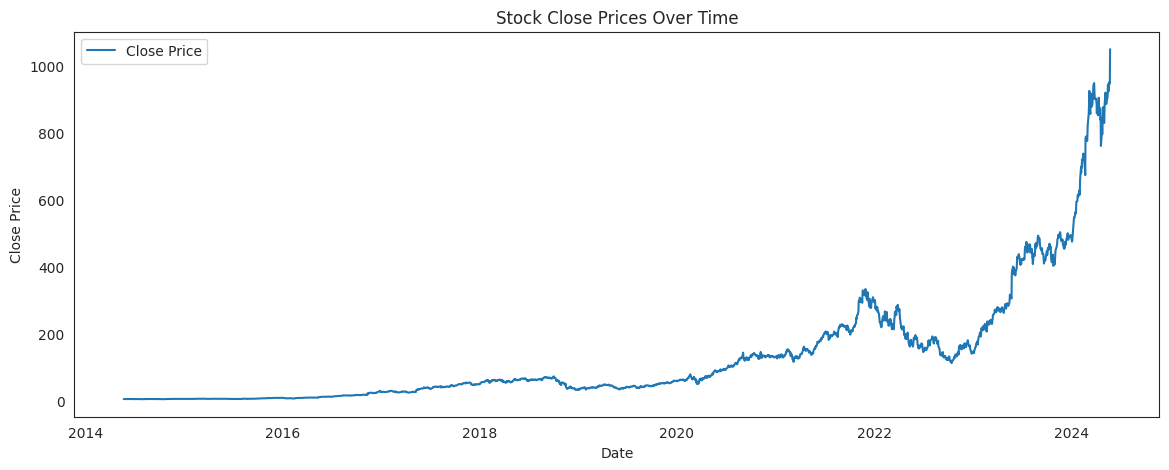

In [ ]:
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('NVDA.csv', parse_dates=['Date'])

# Plot the original 'Close' prices
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


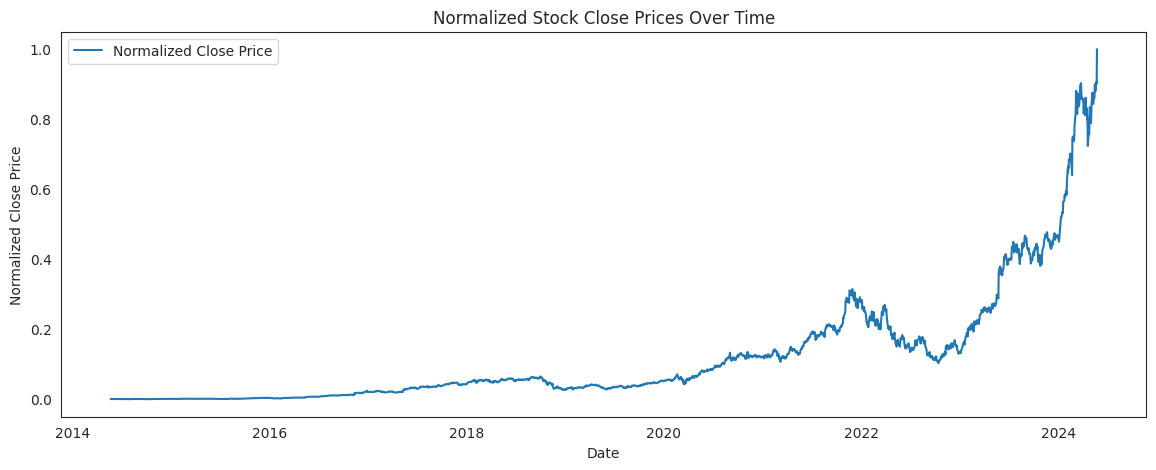

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Plot the normalized 'Close' prices
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], scaled_data, label='Normalized Close Price')
plt.title('Normalized Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()


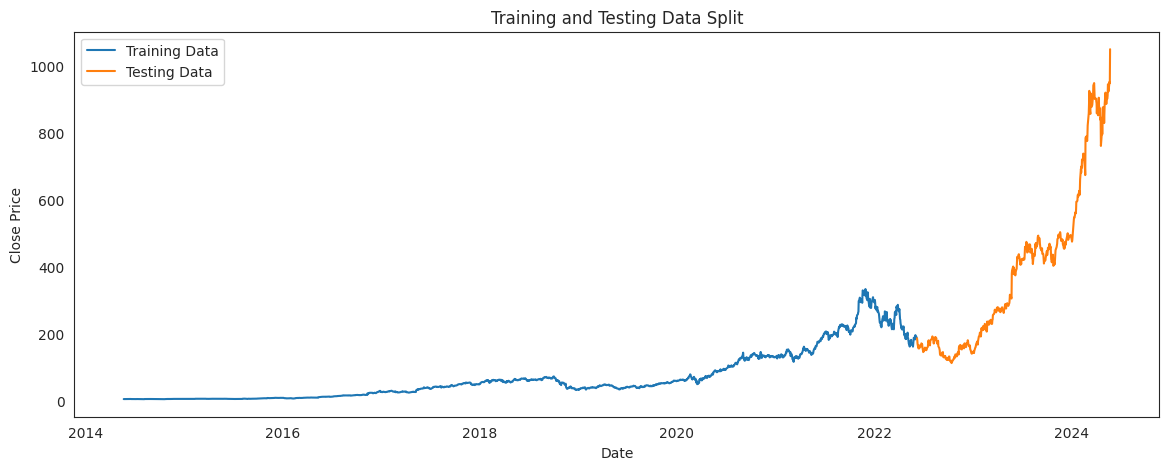

In [ ]:
# Create the dataset for supervised learning
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
train_data, test_data = data[:train_size + time_step], data[train_size + time_step:]

# Plot the training and testing data
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], label='Testing Data')
plt.title('Training and Testing Data Split')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 0/100, Loss: 0.0001
Epoch 10/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000


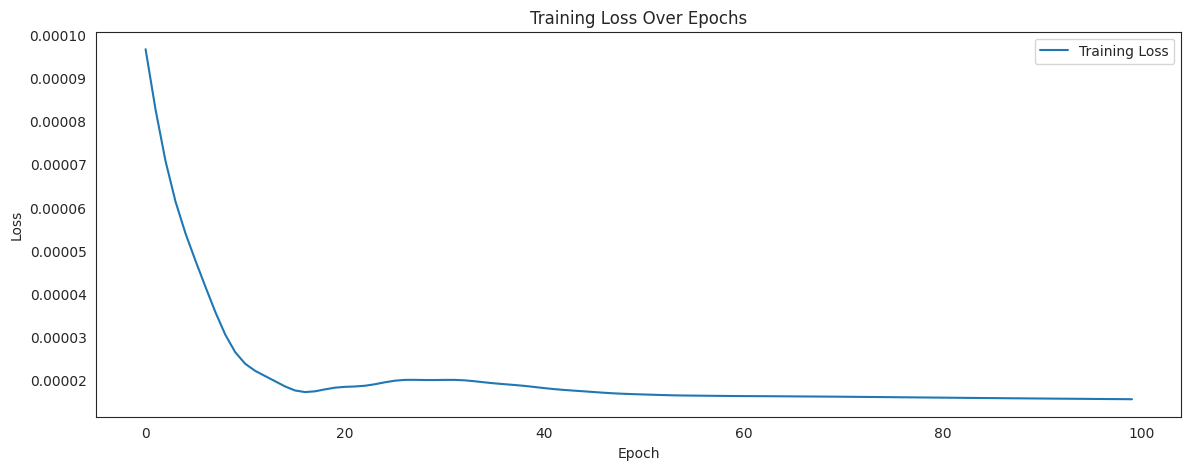

In [ ]:
# Initialize lists to store loss values
loss_values = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensors)
    optimizer.zero_grad()
    loss = criterion(outputs, Y_train_tensors.view(-1, 1))
    loss.backward()
    optimizer.step()

    # Store the loss value
    loss_values.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the training loss
plt.figure(figsize=(14, 5))
plt.plot(range(num_epochs), loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


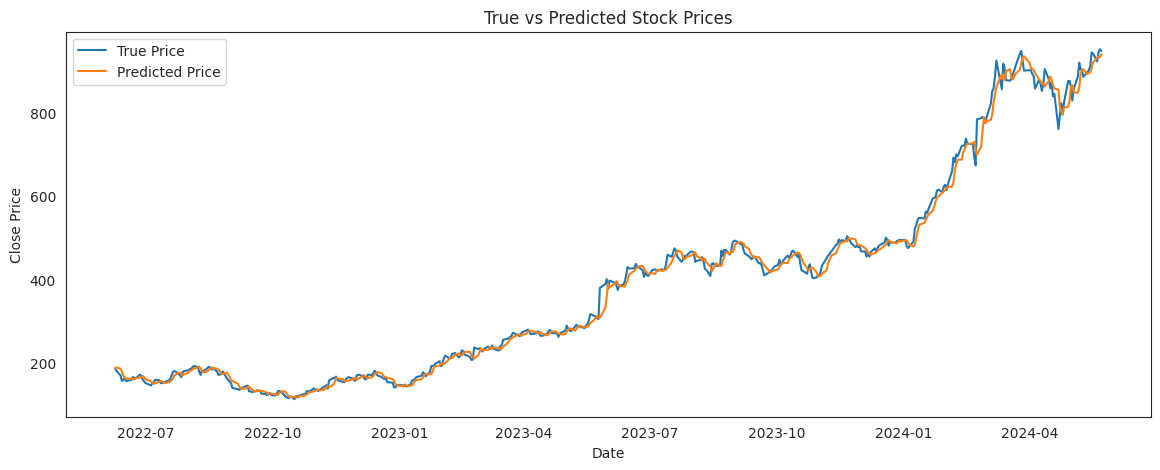

In [ ]:
model.eval()
X_test_tensors = torch.from_numpy(X_test).float()
Y_test_tensors = torch.from_numpy(Y_test).float()

# Make predictions
predicted = model(X_test_tensors)
predicted = predicted.detach().numpy()
predicted = scaler.inverse_transform(predicted)

Y_test_true = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_data['Date'][-len(Y_test_true):], Y_test_true, label='True Price')
plt.plot(test_data['Date'][-len(predicted):], predicted, label='Predicted Price')
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r_squared = r2_score(Y_test_true, predicted)
print("R-squared (R2) =", r_squared)
mse = mean_squared_error(Y_test_true, predicted)
mae = mean_absolute_error(Y_test_true, predicted)
r_squared = r2_score(Y_test_true, predicted)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
#ALPHEBET - 15yrs

R-squared (R2) = 0.962995037992403
Mean Squared Error (MSE): 6.810094294182132
Mean Absolute Error (MAE): 1.8388932822204584
